# Housing Models with Geospatial Features (Best Parameters)

This notebook is nearly identical to the Baseline Models notebook, except that these models include all of the geospatial features. Below, the query radii can be adjusted for the different geospatial datasets for when they are added as features. Also, the date range can be adjusted for the crime and 311 request datasets. The price range can be adjusted for the Assessor dataset and the Airbnb dataset can be adjusted to include only units with a certain amount of reviews per month.

Different categories can be added to or excluded from the Airbnb and Assessor dataset by adjusting the 'short_311_cats' and 'short_crime_cats' lists - categories need to be manually added to the list.

In [3]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import seaborn as sns
from cap_functs import rmse, mae, median_error, find_neigh_cnt, find_cnts_per_cat, compile_model_data
from cap_functs import percent_within_x, print_percents, print_percents_log, convert_mp_vals

from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KDTree
from sklearn.utils import shuffle
from sklearn.metrics import median_absolute_error, make_scorer

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

Load geospatial datasets. Choose date range of crime and 311 data. 

In [8]:
rec_311_dt = pd.read_pickle('../ga_project_data/rec_311_dt')
print max(rec_311_dt.Opened)
rec_15up = rec_311_dt[rec_311_dt.Opened >= datetime.datetime(2015, 1, 1)]
rec_15up = rec_15up[rec_15up.Point.notnull()]
rec_15up['latitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[0])
rec_15up['longitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[1])
del rec_311_dt

2016-08-11 00:57:07


In [9]:
short_311_cats = ['Street and Sidewalk Cleaning', 'Damaged Property', 'SFHA Requests', 
                  'Street Defects', 'Sidewalk or Curb', 'Color Curb', 'Graffiti']

In [10]:
crimes_sf_dt = pd.read_pickle('../ga_project_data/crimes_sf_dt')

crime_15up = crimes_sf_dt[crimes_sf_dt.Date >= datetime.datetime(2015, 1, 1)]
crime_15up = crime_15up.rename(columns={'X': 'longitude', 'Y': 'latitude'})
del crimes_sf_dt

In [11]:
short_crime_cats = ['LARCENY/THEFT', 'VEHICLE THEFT', 'DRUG/NARCOTIC', 'VANDALISM', 
                    'BURGLARY', 'ROBBERY', 'LOITERING', 'NON-CRIMINAL', 'WEAPON LAWS']

In [12]:
park_reg_pts = pd.DataFrame(gpd.read_file('./map_data/park_reg_pts/park_reg_pts.shp'))
park_reg_pts['geometry'] = park_reg_pts.geometry.apply(str, convert_dtype=str)
park_reg_pts = convert_mp_vals(df=park_reg_pts, column='geometry')
park_reg_pts = park_reg_pts[np.random.choice(park_reg_pts.shape[0], 
                                             len(park_reg_pts), replace=False), :]

In [14]:
ldn_76 = pd.read_pickle('ldn_76')
ldn_74 = pd.read_pickle('ldn_74')
ldn_72 = pd.read_pickle('ldn_72')
ldn_70 = pd.read_pickle('ldn_70')
ldn_66 = pd.read_pickle('ldn_66')

Load Airbnb dataset with census tract info added (median income and % below poverty line).

In [15]:
#bnb_list_full = pd.read_pickle('./bnb_list_full')
bnb_list_test = pd.read_pickle('./bnb_list_full_geo')
# Adjust the amount of reviews per month needed to be included in the dataset
# 0.2 is the amount used in the Baseline models, a minimun that ensures people are actually renting
bnb_list_test = bnb_list_test[bnb_list_test.reviews_per_month > 0.2]
bnb_list_test = shuffle(bnb_list_test, random_state=1000)
bnb_list_test.shape

(5187, 93)

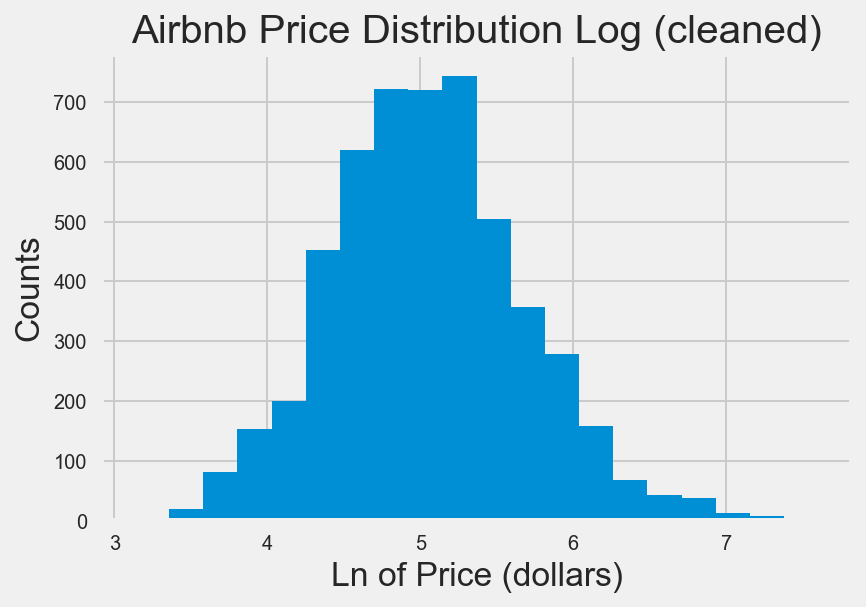

In [16]:
bnb_list_test.price.apply(lambda x: np.log1p(x)).hist(bins=20)
plt.title('Airbnb Price Distribution Log (cleaned)')
plt.xlabel('Ln of Price (dollars)')
plt.ylabel('Counts')
# plt.savefig('Airbnb_price_dist_cleaned_log.pdf', facecolor='w')
plt.show();

Set desired search radius lengths for every category. Adjust the first argument in the function to include categories from the lists above. Use 'crime', '311', or 'crime and 311' to use the different combinations of categories specified in the lists above. 

In [17]:
bnb_list_test = compile_model_data('crime and 311', bnb_list_test, short_311_cats, 
                                   short_crime_cats, crime_15up, rec_15up, 
                                   r_crime=0.004, r_311=0.004)


In [18]:
bnb_list_test = find_neigh_cnt('park_reg_pts', park_reg_pts, bnb_list_test, r=0.004)


In [19]:
bnb_list_test = find_neigh_cnt('ldn_76', ldn_76, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_74', ldn_74, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_72', ldn_72, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_70', ldn_70, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_66', ldn_66, bnb_list_test, r=0.0012)

Below, the results of the NLP models for Airbnb reviews are added (generated in the NLP notebook). The can be added to the datasets, but they do nothing to improve the accuracy of either model.

In [20]:
comments_tfidf = pd.read_pickle('./comments_tfidf')
reviews_sentim = pd.read_pickle('./review_sentiments')
#bnb_list_test = bnb_list_test.merge(reviews_sentim, how='left', left_on='id', right_on='listing_id')
#bnb_list_test = bnb_list_test.merge(comments_tfidf, how='left', left_on='id', right_on='listing_id')
bnb_list_test.head()


,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,...,Street Defects_cnt,Sidewalk or Curb_cnt,Color Curb_cnt,graffiti_cnt,park_reg_pts,ldn_76,ldn_74,ldn_72,ldn_70,ldn_66
6427,9078894,2.0,37.752914,-122.452174,8,3.0,5.0,5.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",575.0,...,21,6,0,21,333,0,0,0,0,38
2289,7034157,6.0,37.745339,-122.503379,3,1.0,1.0,1.0,"{Internet,""Wireless Internet"",Kitchen,Essentia...",80.0,...,14,21,3,126,0,0,0,0,0,160
6241,2177440,1.0,37.757913,-122.442730,1,1.0,1.0,1.0,"{""Cable TV"",""Wireless Internet"",Kitchen,Breakf...",130.0,...,80,88,13,393,159,157,195,279,244,241
3448,9958492,1.0,37.755385,-122.415558,5,1.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",309.0,...,68,129,14,2832,71,78,82,66,126,126
1183,8428506,1.0,37.798427,-122.417552,1,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,Heati...",200.0,...,61,48,11,358,78,0,73,133,234,327


Load tax roll assessor house prices and select range of prices.

In [21]:
#res_rolls_cut = pd.read_pickle('./res_rolls_cut')
res_rolls_test = pd.read_pickle('./res_rolls_cut_geo')
res_rolls_test = res_rolls_test[(res_rolls_test.land_and_impro_val > 100000) & 
                                (res_rolls_test.land_and_impro_val < 7000000)]
res_rolls_test.shape

(293177, 15)

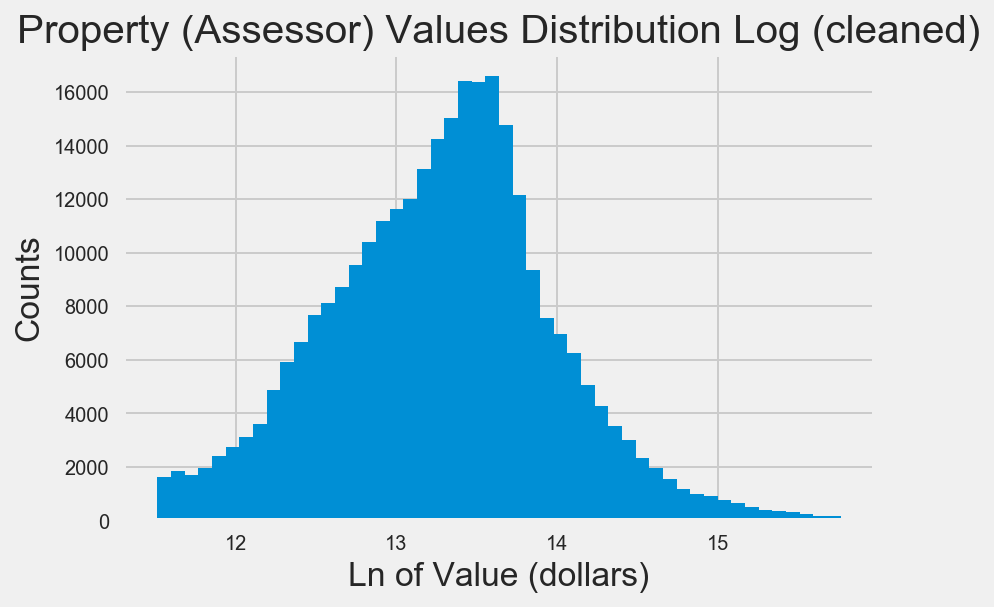

In [22]:
res_rolls_test.land_and_impro_val.apply(lambda x: np.log1p(x)).hist(bins=50)
plt.title('Property (Assessor) Values Distribution Log (cleaned)')
plt.xlabel('Ln of Value (dollars)')
plt.ylabel('Counts')
#plt.savefig('ass_prop_value_dist_cleaned_log.pdf', facecolor='w')
plt.show();

Set desired search radius lengths for every category. Adjust the first argument in the function to include categories from the lists above. Use 'crime', '311', or 'crime and 311' to use the different combinations of categories specified in the lists above.

In [23]:
res_rolls_test = compile_model_data('crime and 311', res_rolls_test, short_311_cats, 
                                    short_crime_cats, crime_15up, rec_15up, 
                                    r_crime=0.003, r_311=0.003)
res_rolls_test.shape

(293177, 30)

In [24]:
res_rolls_test = find_neigh_cnt('park_reg_pts', park_reg_pts, res_rolls_test, r=0.004)


In [25]:
res_rolls_test = find_neigh_cnt('ldn_76', ldn_76, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_74', ldn_74, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_72', ldn_72, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_70', ldn_70, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_66', ldn_66, res_rolls_test, r=0.001)

## Airbnb models

Now, I load the full Airbnb dataset into training and test sets for te predictors (X) and targets (y, or yl for log-tranformed data).

In [26]:
# Predictors and target
# drop_cols = ['price_mod', 'price_y', 'price', 'latitude', 'longitude', 
#              'amenities']
drop_cols = ['id', 'id_x', 'price_mod', 'price_y', 'price', 'latitude', 'longitude', 
             'amenities', 'amenities_x', 'geometry', 'census_tract', 'listing_id']
keep_cols = [x for x in bnb_list_test.columns.values if x not in drop_cols]
X = bnb_list_test[keep_cols]

# ss = StandardScaler()
# Xs = ss.fit_transform(X)

y = bnb_list_test.price.values
yl = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.3, random_state=101)


### Linear Regression

In [27]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

linreg.score(X_test, y_test)

94.3918979723    9.71554928825
58.0970059179
39.9704349782


0.60611868776507061

In [28]:
linregl = LinearRegression()
linregl.fit(Xl_train, yl_train)
yl_pred = linregl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

linregl.score(Xl_test, yl_test)

85.7371924817
46.2561110119
25.5592402445


0.72820293122283863

In [29]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   10.854
Percent within 10 of price:  21.773
Percent within 20 of price:  42.197

Median error (percent):      24.548

Percent within 5 of price:   14.708
Percent within 10 of price:  29.351
Percent within 20 of price:  54.656

Median error (percent):      17.904


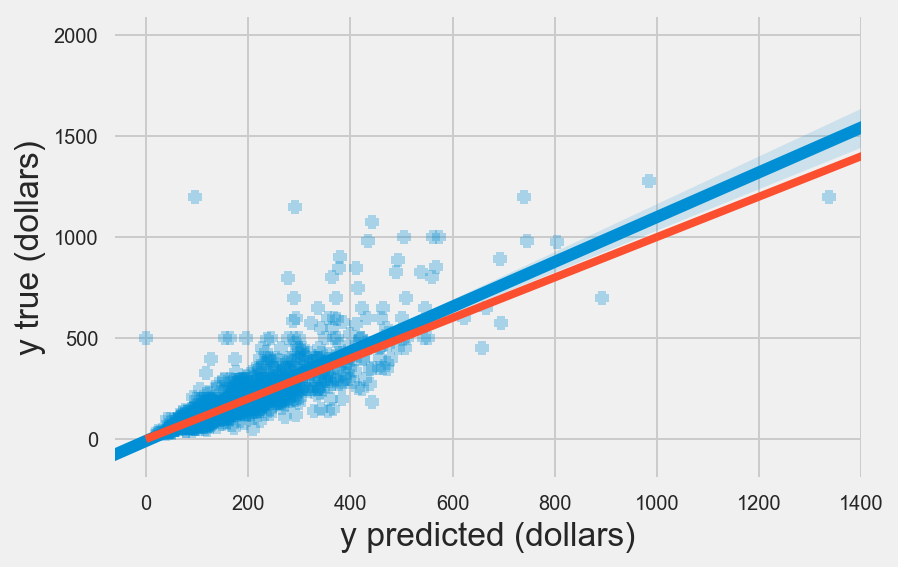

In [30]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
plt.xlabel('y predicted (dollars)')
plt.ylabel('y true (dollars)');
# plt.xlim((0,3000))
# plt.ylim((0,3000));

### Random Forest

In [31]:
rfr = RandomForestRegressor(n_estimators=500, n_jobs=4, min_samples_split=4, 
                             min_samples_leaf=1, max_features= 'auto')
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

rfr.score(X_test, y_test)

85.7255682759
47.783501263
25.7151698413


0.6751247069848425

In [32]:
rfrl = RandomForestRegressor(n_estimators=500, n_jobs=4, min_samples_split=4, 
                             min_samples_leaf=1, max_features= 'auto')
rfrl.fit(Xl_train, yl_train)
yl_pred = rfrl.predict(Xl_test)

print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

rfrl.score(Xl_test, yl_test)

84.6005438132
44.9148900306
22.4147084808


0.79073867675376885

In [33]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   17.534
Percent within 10 of price:  32.820
Percent within 20 of price:  56.262

Median error (percent):      16.984

Percent within 5 of price:   18.304
Percent within 10 of price:  35.003
Percent within 20 of price:  59.666

Median error (percent):      15.391


In [34]:
params = {'n_estimators':(300, 400, 500), 
          'min_samples_split': (2, 3, 4), 
          'min_samples_leaf': (1, 2), 
          'max_features': ('auto', 'sqrt')}
          #'oob_score': (False, True)}

rfrl = RandomForestRegressor(n_jobs=6)
gs_rfrl = GridSearchCV(rfrl, params, verbose=1)
gs_rfrl.fit(Xl_train, yl_train)
gs_rfrl.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  8.0min finished


{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [36]:
def median_absolute_error_log(y_true, y_pred):
    return np.median(np.abs(np.expm1(y_pred) - np.expm1(y_true)))

med_abs_err_log = make_scorer(median_absolute_error_log, greater_is_better=False)

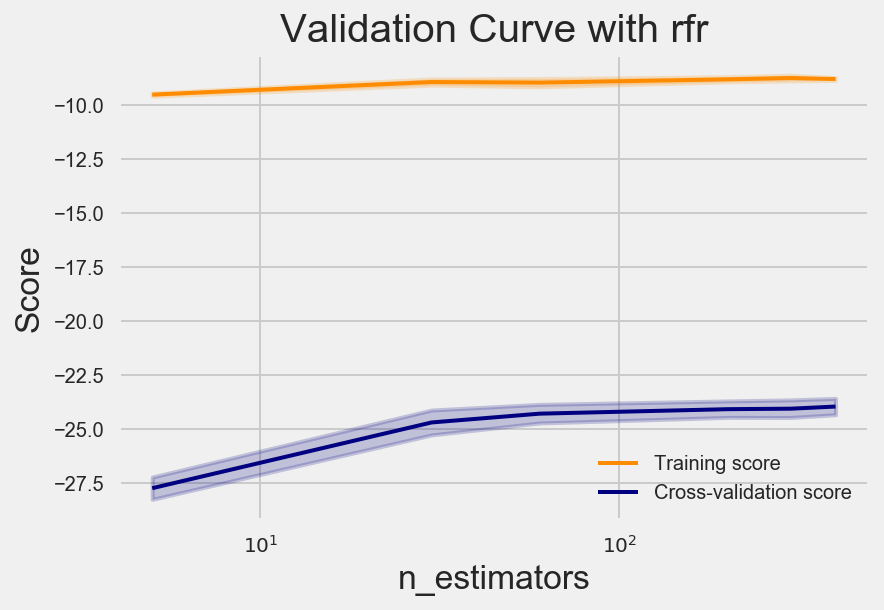

In [38]:
param_range = np.array([5, 30, 60, 200, 300, 400])
rfrl = RandomForestRegressor(n_jobs=4, min_samples_split=2, 
                             min_samples_leaf=1)

train_scores, test_scores = validation_curve(rfrl, X, yl, param_name='n_estimators', 
                                             param_range=param_range, cv=4, 
                                             scoring=med_abs_err_log)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with rfr")
plt.xlabel("n_estimators")
plt.ylabel("Score")
# plt.ylim(-0.3, 0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

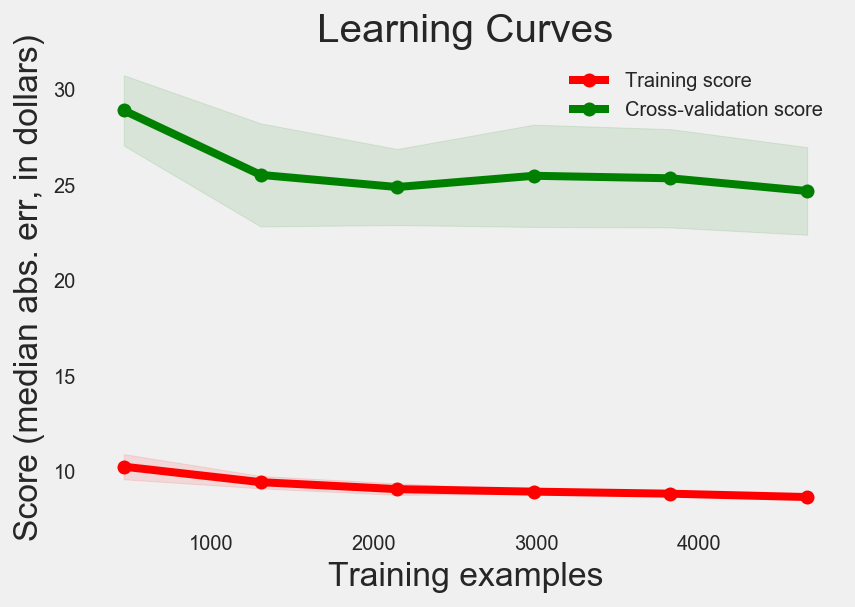

In [42]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    plt.figure()
    plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score (median abs. err, in dollars)")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring=med_abs_err_log)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(np.abs(train_sizes), np.abs(train_scores_mean - train_scores_std),
                     np.abs(train_scores_mean + train_scores_std), alpha=0.1,
                     color="r")
    plt.fill_between(np.abs(train_sizes), np.abs(test_scores_mean - test_scores_std),
                     np.abs(test_scores_mean + test_scores_std), alpha=0.1, color="g")
    plt.plot(train_sizes, np.abs(train_scores_mean), 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, np.abs(test_scores_mean), 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

rfrl = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1)
title = "Learning Curves"
cv = ShuffleSplit(n_splits=4, random_state=100)
plot_learning_curve(rfrl, title, X, yl, (0.1, 1.01), cv=cv, n_jobs=6)
plt.show()

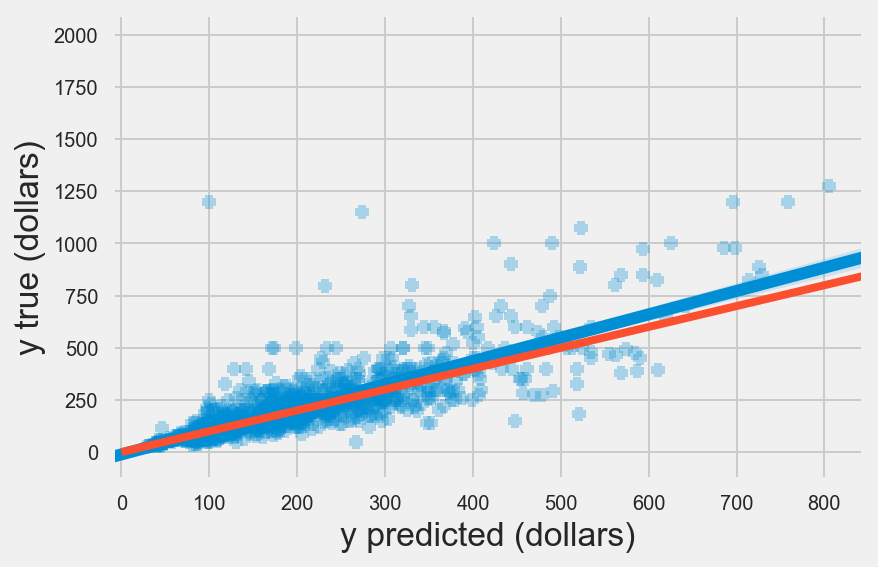

In [43]:
## sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
plt.xlabel('y predicted (dollars)')
plt.ylabel('y true (dollars)');

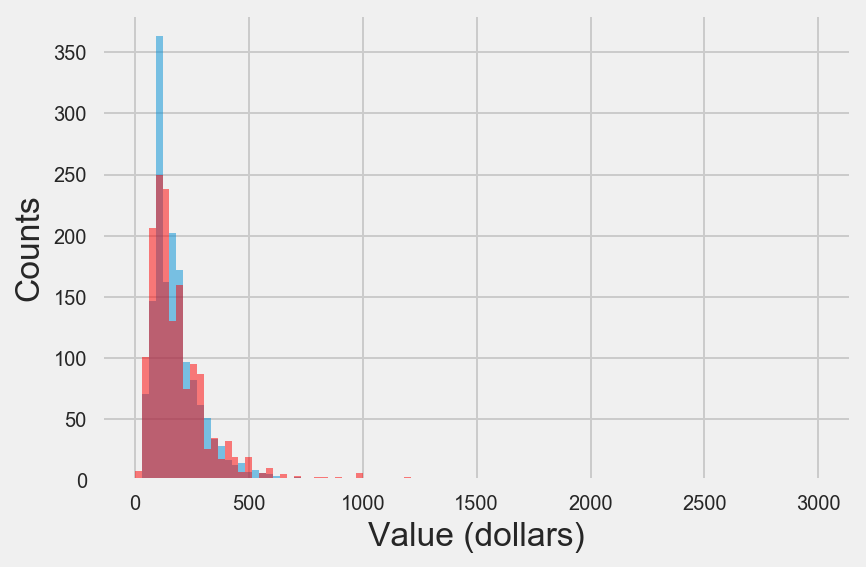

In [44]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,3000, num=100), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,3000, num=100), alpha=0.5, color='r')
plt.xlabel('Value (dollars)')
plt.ylabel('Counts');

### XGBoost

In [45]:
xgb = XGBRegressor(learning_rate= 0.02, max_depth= 5, n_estimators= 1000, 
                   reg_lambda= 2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

xgb.score(X_test, y_test)

79.9219089986    8.93990542448
44.501308353
24.7792282104


0.71762409465172039

In [46]:
xgbl = XGBRegressor(learning_rate= 0.02, max_depth= 5, n_estimators= 1000, 
                    reg_lambda= 2)
xgbl.fit(Xl_train, yl_train)
yl_pred = xgbl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

xgbl.score(Xl_test, yl_test)

77.3374177246
40.7759026372
21.2359466553


0.81905064097417868

In [47]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   17.148
Percent within 10 of price:  32.627
Percent within 20 of price:  56.583

Median error (percent):      17.365

Percent within 5 of price:   19.204
Percent within 10 of price:  36.545
Percent within 20 of price:  62.492

Median error (percent):      14.789


In [271]:
params = {'n_estimators':(800, 1000, 1200), 
          'learning_rate': (0.01, 0.02, 0.03), 
          'reg_lambda': (2, 5, 8), 
          'max_depth': (3, 4, 5)}

xgbl = XGBRegressor()
gs_xgbl = GridSearchCV(xgbl, params, n_jobs=4, verbose=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed: 13.1min finished


{'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 2}

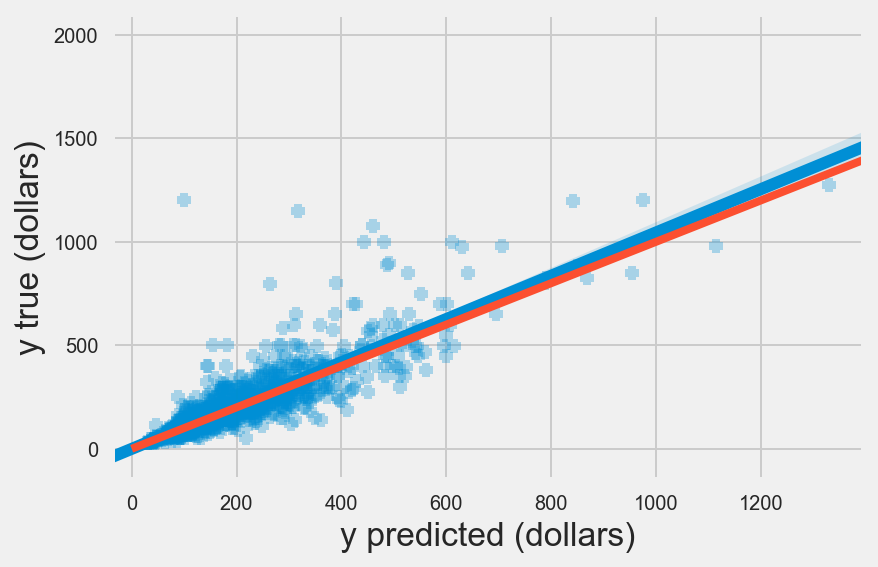

In [48]:
## sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
plt.xlabel('y predicted (dollars)')
plt.ylabel('y true (dollars)');

### Gradient Boosted Trees

In [49]:
gbr = GradientBoostingRegressor(max_depth= 5, max_features= 'sqrt', min_samples_leaf= 3,
                                 min_samples_split= 6, n_estimators= 300)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

gbr.score(X_test, y_test)

80.4187604913
45.1724445101
25.6136799926


0.71410228215448346

In [50]:
gbrl = GradientBoostingRegressor(max_depth= 5, max_features= 'sqrt', min_samples_leaf= 3,
                                 min_samples_split= 6, n_estimators= 300)
gbrl.fit(Xl_train, yl_train)
yl_pred = gbrl.predict(Xl_test)
print rmse(yl_pred, yl_test), '  ', np.sqrt(rmse(yl_pred, yl_test))
print mae(yl_pred, yl_test)
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

gbrl.score(Xl_test, yl_test)

0.27784800432    0.527112895232
0.200805362764
21.2482544424


0.8109259620018634

In [51]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   16.956
Percent within 10 of price:  32.306
Percent within 20 of price:  54.335

Median error (percent):      17.576

Percent within 5 of price:   19.974
Percent within 10 of price:  35.710
Percent within 20 of price:  61.657

Median error (percent):      15.247


In [52]:
params = {'n_estimators':(200, 300, 400), 
          'min_samples_split': (3, 4, 5, 6), 
          'min_samples_leaf': (1, 2, 3), 
          'max_depth': (3, 4, 5), 
          'max_features': ('auto', 'sqrt')}

xgbl = GradientBoostingRegressor()
gs_xgbl = GridSearchCV(xgbl, params, n_jobs=6, verbose=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   21.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 648 out of 648 | elapsed:  6.0min finished


{'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 400}

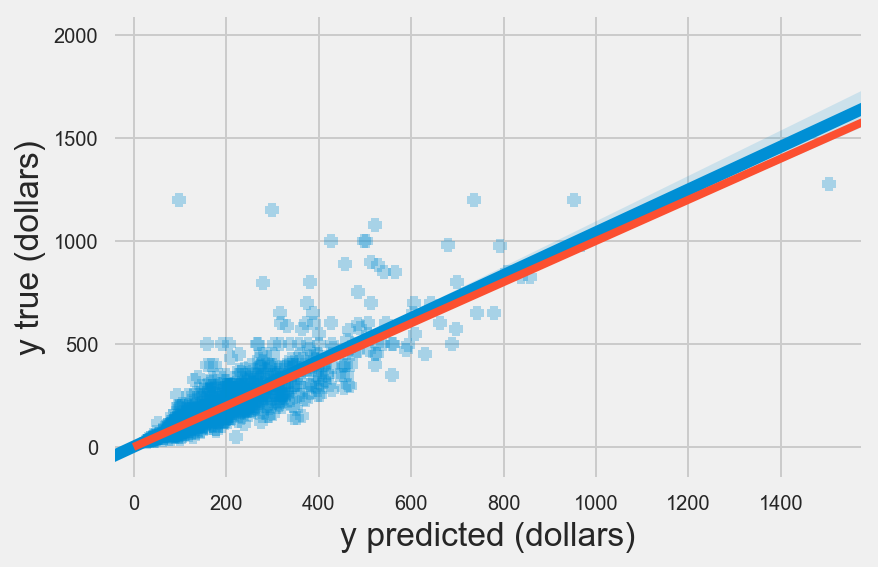

In [53]:
## sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
plt.xlabel('y predicted (dollars)')
plt.ylabel('y true (dollars)');

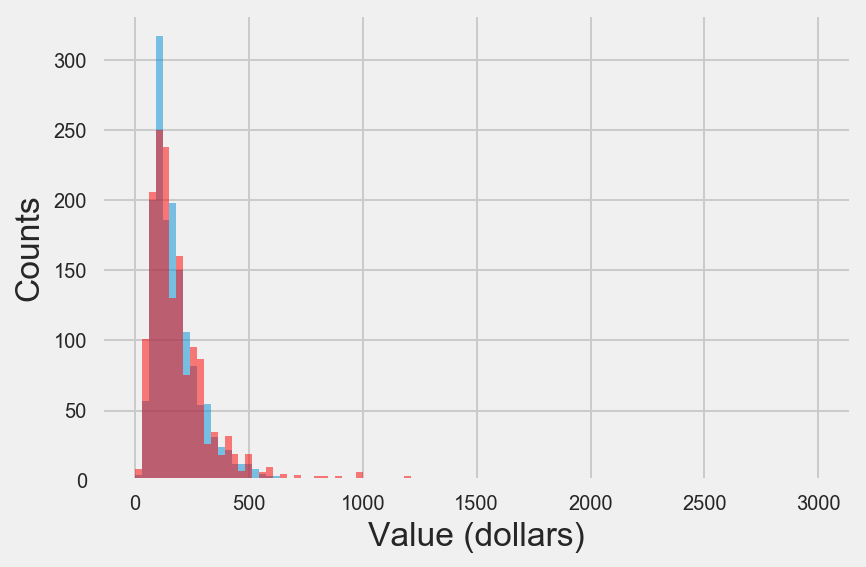

In [54]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,3000, num=100), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,3000, num=100), alpha=0.5, color='r')
plt.xlabel('Value (dollars)')
plt.ylabel('Counts');

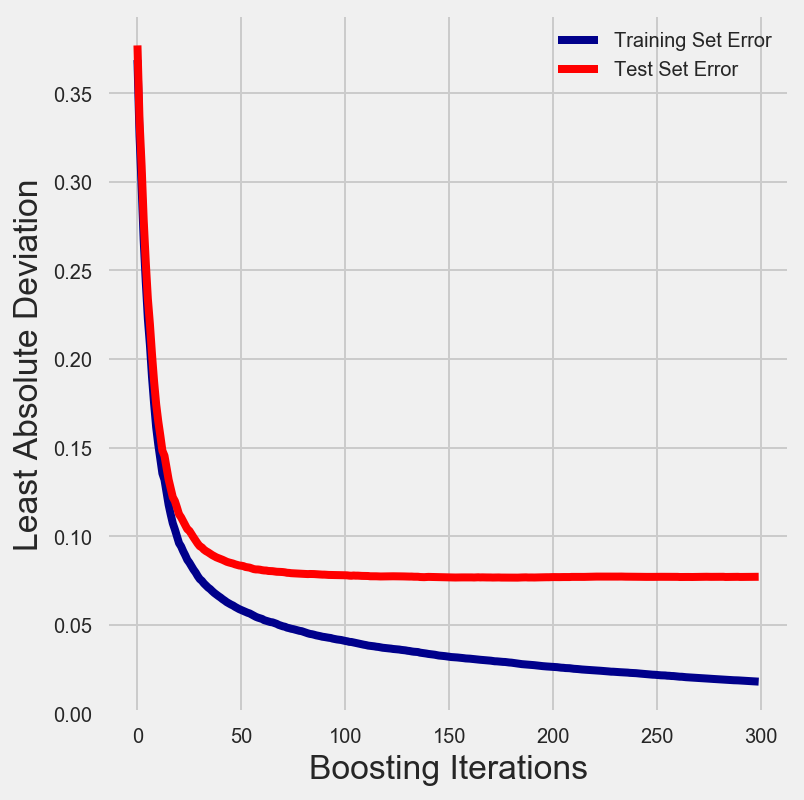

In [56]:
# plot error for each round of boosting
n_est = 300
test_score = np.zeros(n_est, dtype=np.float64)

train_score = gbrl.train_score_
for i, yl_pred in enumerate(gbrl.staged_predict(Xl_test)):
    test_score[i] = gbrl.loss_(yl_test, yl_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation');

In [57]:
# Pickle these items for availability in the NLP notebook
# pd.to_pickle(Xl_train, 'X_train')
# pd.to_pickle(yl_train, 'y_train')
# pd.to_pickle(Xl_test, 'X_test')
# pd.to_pickle(yl_test, 'y_test')
# pd.to_pickle(yl_pred_xgb, 'y_pred')
# pd.to_pickle(bnb_list_test['id'], 'idx_id')
# pd.to_pickle(bnb_list_test, 'bnb_list_test')

### ExtraTrees

In [65]:
etr = ExtraTreesRegressor(n_jobs=4, n_estimators=500, bootstrap=True, 
                          min_samples_split=5, min_samples_leaf=1)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

etr.score(X_test, y_test)

85.2822834119    9.2348407356
46.5033947727
25.0005235931


0.6784758648921474

In [66]:
etrl = ExtraTreesRegressor(n_jobs=4, n_estimators=500, bootstrap=True,
                           min_samples_split=5, min_samples_leaf=1)
etrl.fit(Xl_train, yl_train)
yl_pred = etrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

etrl.score(Xl_test, yl_test)


84.1366517089
44.0174873556
22.825155418


0.79374547300668019

In [67]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   17.791
Percent within 10 of price:  32.948
Percent within 20 of price:  57.290

Median error (percent):      16.625

Percent within 5 of price:   17.919
Percent within 10 of price:  35.645
Percent within 20 of price:  59.152

Median error (percent):      15.637


In [61]:
params = {'n_estimators':(300, 400, 500), 
          'min_samples_split': (4, 5, 6, 7), 
          'min_samples_leaf': (1, 2), 
          'max_depth': (4, 5, 6)}

xtrl = ExtraTreesRegressor(bootstrap=True)
gs_xtrl = GridSearchCV(xtrl, params, n_jobs=6, verbose=1)
gs_xtrl.fit(Xl_train, yl_train)
gs_xtrl.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   29.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 216 out of 216 | elapsed:  3.5min finished


{'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

### Ensemble results from different models by averaging predictions

In [127]:
yl_pred_mean = (yl_pred_gbr + yl_pred_xgb + yl_pred_rfr)/2.

In [128]:
yl_pred_mean

array([ 4.74584298,  5.59347918,  4.52519184, ...,  5.424117  ,
        5.53235138,  6.0470794 ])

In [129]:
print 'mae (sklearn): {}'.format(median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred_mean)))
print
print_percents_log(yl_pred_mean, yl_test)

mae (sklearn): 21.7462505478

Percent within 5 of price:   19.011
Percent within 10 of price:  34.489
Percent within 20 of price:  61.785

Median error (percent):      15.035


## Property (tax roll) models

Now, I load the full Assessor's property dataset into training and test sets for te predictors (X) and targets (y, or yl for log-tranformed data).

In [71]:
# Predictors and target

drop_cols = ['latitude', 'longitude', 'land_and_impro_val', 'geometry', 'census_tract']
keep_cols = [x for x in res_rolls_test.columns.values if x not in drop_cols]
X = res_rolls_test[keep_cols]

# ss = StandardScaler()
# Xs = ss.fit_transform(X)

y = res_rolls_test.land_and_impro_val.values
yl = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.25, random_state=100)


In [72]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)

linreg.score(X_test, y_test)

537329.624936    733.027710892
340987.448443


0.29707157374163073

In [73]:
linregl = LinearRegression()
linregl.fit(Xl_train, yl_train)
yl_pred = linregl.predict(Xl_test)
print rmse(yl_pred, yl_test), '  ', np.sqrt(rmse(yl_pred, yl_test))
print mae(yl_pred, yl_test)

linregl.score(Xl_test, yl_test)

0.604117131522    0.777249722755
0.47707008972


0.2547976450621906

In [74]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   6.779
Percent within 10 of price:  13.536
Percent within 20 of price:  27.033

Median error (percent):      37.993

Percent within 5 of price:   5.878
Percent within 10 of price:  12.203
Percent within 20 of price:  24.895

Median error (percent):      37.518


### Random Forest

In [75]:
rfr = RandomForestRegressor(n_estimators=600, n_jobs=3, 
                            min_samples_split=3, min_samples_leaf=1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
rfr.score(X_test, y_test)

232560.856587
107666.804548
41525.9137385


0.86832516818951833

In [76]:
rfrl = RandomForestRegressor(n_estimators=600, n_jobs=3, 
                             min_samples_split=3, min_samples_leaf=1)
rfrl.fit(Xl_train, yl_train)
yl_pred = rfrl.predict(Xl_test)

print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

rfrl.score(Xl_test, yl_test)

248615.746648
110248.865431
37897.745844


0.85627748868030462

In [77]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   40.004
Percent within 10 of price:  60.001
Percent within 20 of price:  77.043

Median error (percent):      6.890

Percent within 5 of price:   42.090
Percent within 10 of price:  61.857
Percent within 20 of price:  78.175

Median error (percent):      6.384


In [32]:
params = {'n_estimators': (600, 700, 800),
          'min_samples_split': (3, 4, 5),
          'min_samples_leaf': (1, 2)}

rfrl = RandomForestRegressor(n_jobs=-1)
gs_rfrl = GridSearchCV(rfrl, params, verbose=6, pre_dispatch=1)
gs_rfrl.fit(Xl_train, yl_train)
gs_rfrl.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] min_samples_split=3, n_estimators=600, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=600, min_samples_leaf=1, score=0.803721, total=  58.5s
[CV] min_samples_split=3, n_estimators=600, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=600, min_samples_leaf=1, score=0.811735, total=  59.6s
[CV] min_samples_split=3, n_estimators=600, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=600, min_samples_leaf=1, score=0.805012, total=  59.2s
[CV] min_samples_split=3, n_estimators=700, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=700, min_samples_leaf=1, score=0.803998, total= 1.1min
[CV] min_samples_split=3, n_estimators=700, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.3min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=700, min_samples_leaf=1, score=0.811721, total= 1.2min
[CV] min_samples_split=3, n_estimators=700, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=700, min_samples_leaf=1, score=0.804545, total= 1.2min
[CV] min_samples_split=3, n_estimators=800, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=800, min_samples_leaf=1, score=0.803797, total= 1.3min
[CV] min_samples_split=3, n_estimators=800, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=800, min_samples_leaf=1, score=0.811799, total= 1.3min
[CV] min_samples_split=3, n_estimators=800, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=800, min_samples_leaf=1, score=0.804532, total= 1.3min
[CV] min_samples_split=4, n_estimators=600, min_samples_leaf=1 .......
[CV]  min_samples_split=4, n_estimators=600, min_samples_leaf=1, score=0.801830, total=  57.9s
[CV] min_samples_split=4, n_estimators=600, min_samples_leaf=1 .......
[CV]  min_samples_split=4, n_estimators=600, min_samples_leaf=1, score=0.809495, total=  57.8s
[CV] min_samples_split=4, n_estimators=600, min_samples_leaf=1 .......
[CV]

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 61.9min finished


{'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600}

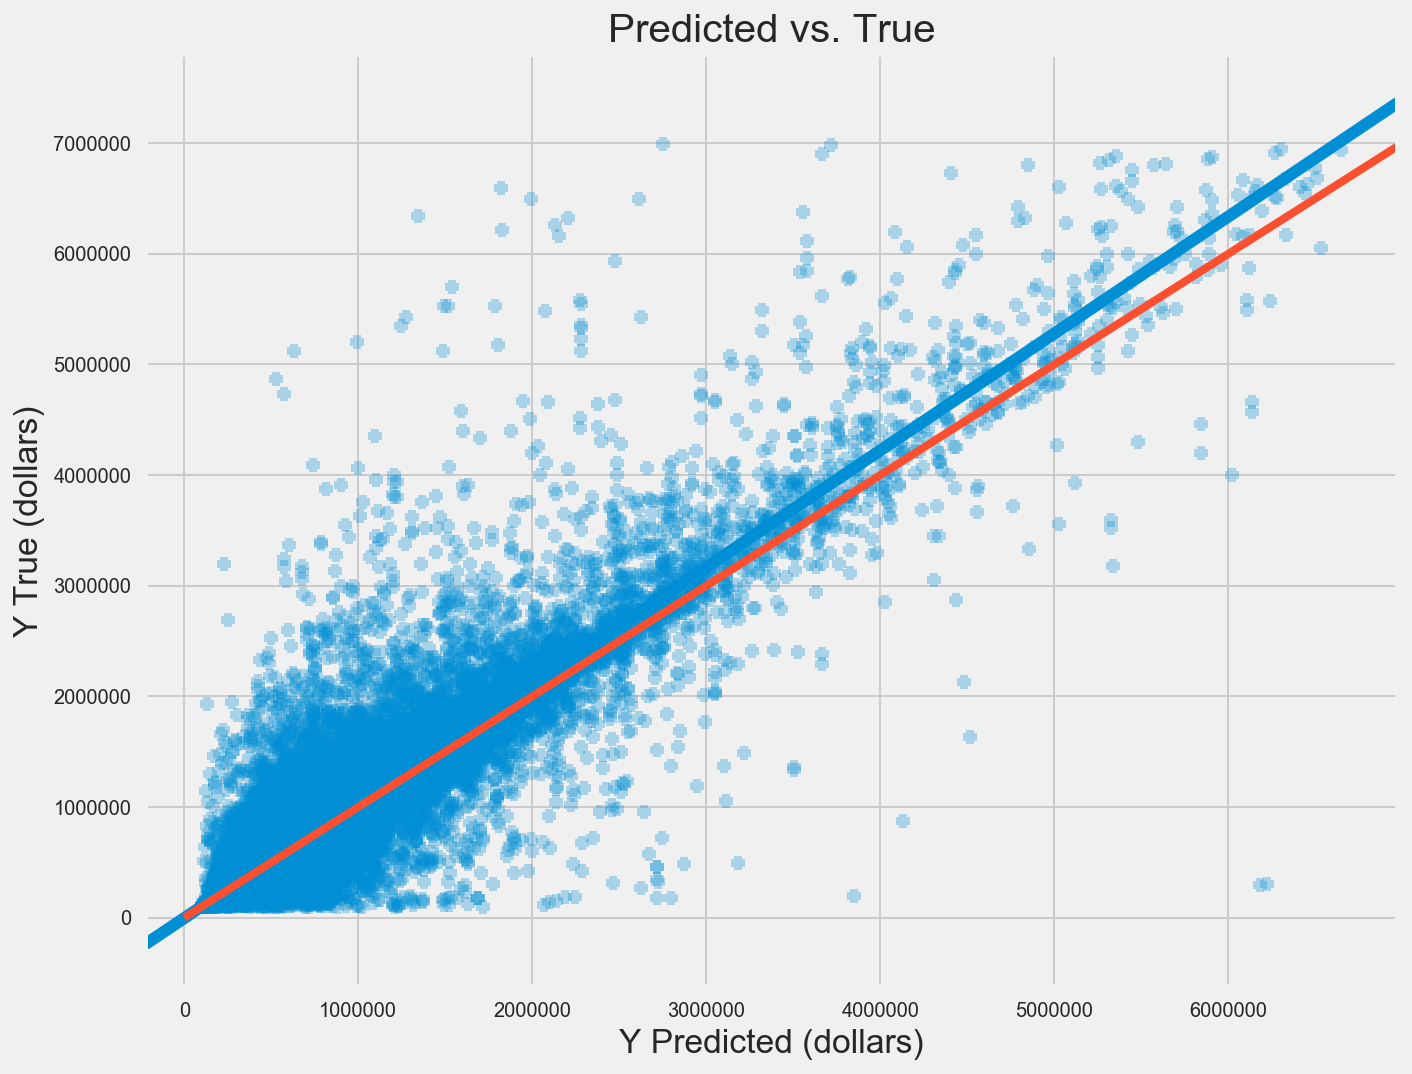

In [78]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
plt.figure(figsize=(10,8))
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,7000000), range(0,7000000))
plt.xlabel('Y Predicted (dollars)')
plt.ylabel('Y True (dollars)')
plt.title('Predicted vs. True')
plt.show();

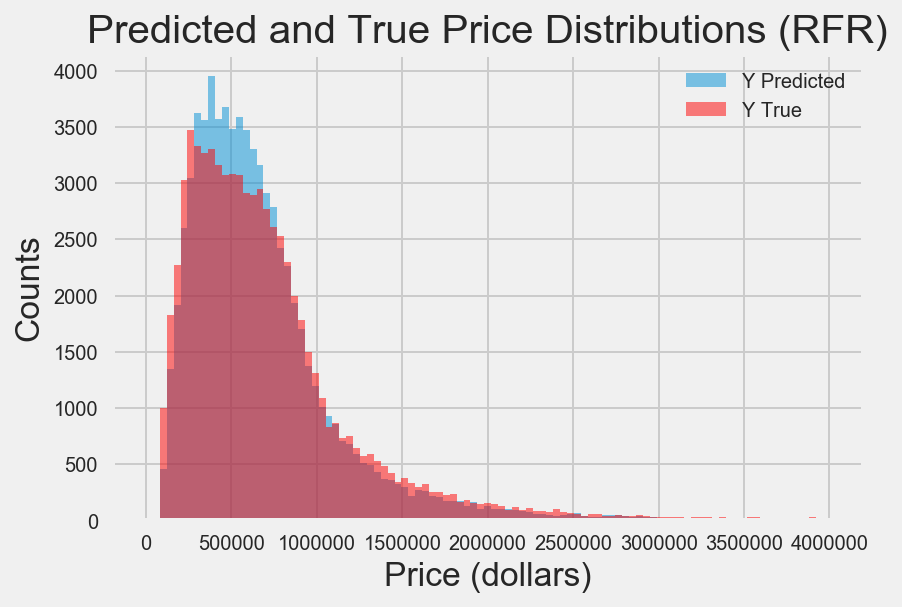

In [79]:
# plt.hist(yl_pred, bins=np.linspace(10,20, num=80), alpha=0.5)
# plt.hist(yl_test, bins=np.linspace(10,20, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,4000000, num=100), alpha=0.5, label='Y Predicted')
plt.hist(np.expm1(yl_test), bins=np.linspace(0,4000000, num=100), alpha=0.5, color='r', label='Y True');
plt.title('Predicted and True Price Distributions (RFR)')
plt.xlabel('Price (dollars)')
plt.ylabel('Counts')
plt.legend()
# plt.savefig('ass_best_pred_true_dist_rfr')
plt.show();

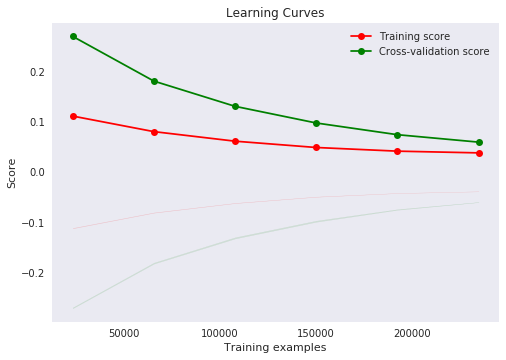

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    plt.figure()
    plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring="neg_median_absolute_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, np.abs(train_scores_mean), 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, np.abs(test_scores_mean), 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

rfrl = RandomForestRegressor(n_estimators=600, n_jobs=-1, 
                             min_samples_split=3, min_samples_leaf=1)
title = "Learning Curves"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=100)
plot_learning_curve(rfrl, title, X, yl, (0.2, 1.01), cv=cv)
plt.ylim((0,0.4))
plt.savefig('ass_best_rfr_median_ae_LC.pdf')
plt.show()

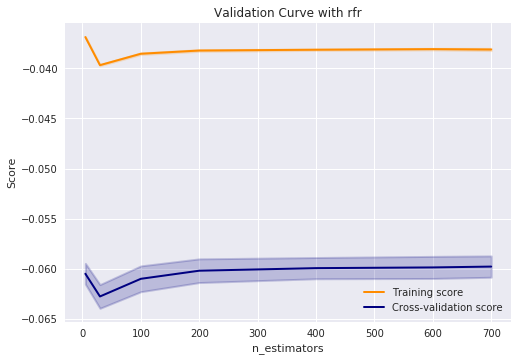

In [35]:
param_range = np.array([5, 30, 100, 200, 400, 600, 700])
rfrl = RandomForestRegressor(n_estimators=600, n_jobs=-1, 
                             min_samples_split=3, min_samples_leaf=1)

train_scores, test_scores = validation_curve(rfrl, X, yl, param_name='n_estimators', 
                                             param_range=param_range, cv=5, 
                                             scoring="neg_median_absolute_error")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with rfr")
plt.xlabel("n_estimators")
plt.ylabel("Score")
#plt.ylim(0.4, 1.0)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig('ass_best_rfr_median_ae_VC.pdf')
plt.show()

### ExtraTrees

In [80]:
etr = ExtraTreesRegressor(n_jobs=3, n_estimators=400, bootstrap=True,
                           max_depth=5, min_samples_leaf=3, 
                           min_samples_split= 6)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

etr.score(X_test, y_test)

514153.774276    717.045168923
332439.852124
37897.745844


0.35640065726086256

In [81]:
etrl = ExtraTreesRegressor(n_jobs=3, n_estimators=400, bootstrap=True,
                           max_depth=5, min_samples_leaf=3, 
                           min_samples_split= 6)
etrl.fit(Xl_train, yl_train)
yl_pred = etrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
etrl.score(Xl_test, yl_test)


562507.668588
335422.575989
222975.3015


0.26925357876365663

In [82]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   7.444
Percent within 10 of price:  14.893
Percent within 20 of price:  29.868

Median error (percent):      35.973

Percent within 5 of price:   5.823
Percent within 10 of price:  12.036
Percent within 20 of price:  25.193

Median error (percent):      36.757


In [65]:
params = {'n_estimators':(300, 400, 500), 
          'min_samples_split': (4, 5, 6), 
          'min_samples_leaf': (1, 2, 3), 
          'max_depth': (3, 4, 5), 
          'max_features': ('auto', 'sqrt')}

xtrl = ExtraTreesRegressor(bootstrap=True, n_jobs=-1)
gs_xtrl = GridSearchCV(xtrl, params, verbose=6, pre_dispatch=1)
gs_xtrl.fit(Xl_train, yl_train)
gs_xtrl.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.178229, total=   2.4s
[CV] max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.177212, total=   2.3s
[CV] max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.178403, total=   2.5s
[CV] max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1, score=0.177025, total=   3.1s
[CV] max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1, score=0.177518, total=   3.3s
[CV] max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1, score=0.176258, total=   3.3s
[CV] max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1, score=0.176864, total=   4.2s
[CV] max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1, score=0.176846, total=   3.8s
[CV] max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1, score=0.174554, total=   3.9s
[CV] max_features=auto, min_samples_split=5, n_estimators=300, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=5, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.180

[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed: 31.3min finished


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 400}

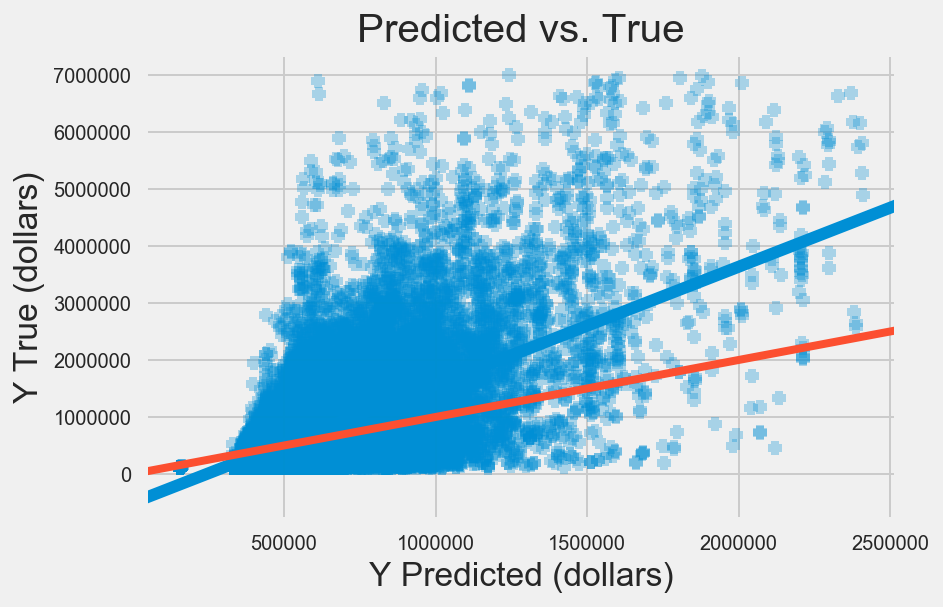

In [83]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,4000000), range(0,4000000))
plt.xlabel('Y Predicted (dollars)')
plt.ylabel('Y True (dollars)')
plt.title('Predicted vs. True')
plt.show();

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


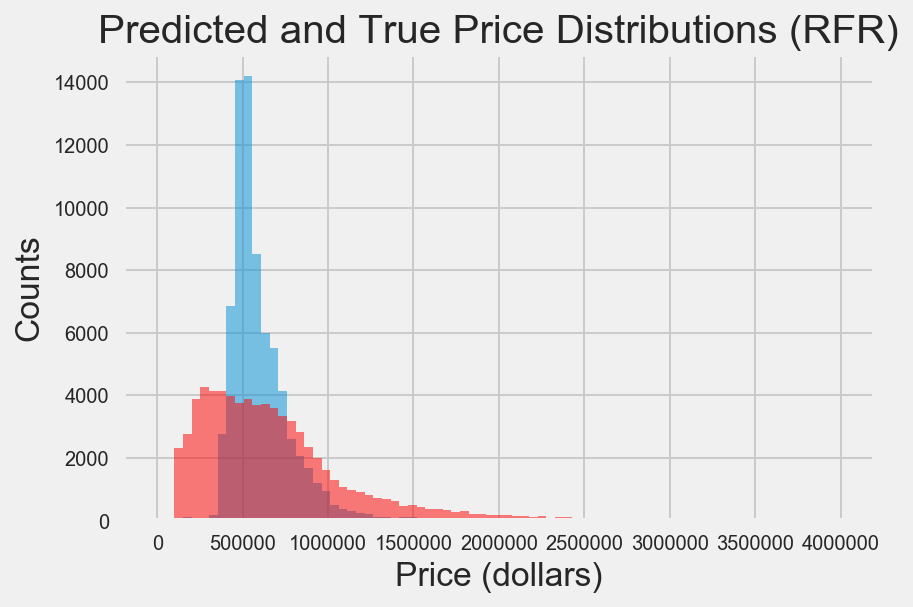

In [84]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,4000000, num=80), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,4000000, num=80), alpha=0.5, color='r')
plt.title('Predicted and True Price Distributions (RFR)')
plt.xlabel('Price (dollars)')
plt.ylabel('Counts')
plt.legend()
# plt.savefig('ass_best_pred_true_dist_rfr')
plt.show();

### XGBoost

In [85]:
xgb = XGBRegressor(learning_rate = 0.08, max_depth = 5, 
                    n_estimators = 1000, reg_lambda = 0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
xgb.score(X_test, y_test)

355637.085468    596.353154992
241118.273085


0.69207594278961171

In [86]:
xgbl = XGBRegressor(learning_rate = 0.08, max_depth = 5, 
                    n_estimators = 1000, reg_lambda = 0.1)
xgbl.fit(Xl_train, yl_train)
yl_pred = xgbl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
xgbl.score(Xl_test, yl_test)

398104.284787
246314.092546


0.56143984783583711

In [87]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   9.818
Percent within 10 of price:  19.548
Percent within 20 of price:  38.329

Median error (percent):      26.866

Percent within 5 of price:   9.470
Percent within 10 of price:  18.694
Percent within 20 of price:  36.711

Median error (percent):      27.824


In [83]:
params = {'n_estimators':(800, 1000), 
          'learning_rate': (0.01, 0.02, 0.08), 
          'reg_lambda': (0.1, 2, 10), 
          'max_depth': (3, 4, 5)}

xgbl = XGBRegressor(nthread=-1)
gs_xgbl = GridSearchCV(xgbl, params, verbose=6, pre_dispatch=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.355963, total=   8.2s
[CV] n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.353329, total=   8.0s
[CV] n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.9s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.349489, total=   8.1s
[CV] n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.3s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3, score=0.356024, total=   8.1s
[CV] n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.8s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3, score=0.352805, total=   8.2s
[CV] n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3 .


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.3s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3, score=0.349013, total=   7.9s
[CV] n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3, score=0.354119, total=   7.9s
[CV] n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3, score=0.350768, total=   8.0s
[CV] n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3, score=0.347619, total=   8.0s
[CV] n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.362462, total=   9.8s
[CV] n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.359924, total=   9.9s
[CV] n_estimators=1000, re

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 33.0min finished


{'learning_rate': 0.08,
 'max_depth': 5,
 'n_estimators': 1000,
 'reg_lambda': 0.1}

### Gradient Boosted Trees

In [88]:
gbr = GradientBoostingRegressor(n_estimators=300)#, min_samples_split=7, min_samples_leaf=3)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
gbr.score(X_test, y_test)

434301.14988
284371.136455
195601.07977


0.54078983394567137

In [89]:
gbrl = GradientBoostingRegressor(n_estimators=300)#, min_samples_split=7, min_samples_leaf=3)
gbrl.fit(Xl_train, yl_train)
yl_pred = gbrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
gbrl.score(Xl_test, yl_test)

463943.214656
285748.405343
185993.879513


0.43542706495382999

In [90]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   8.519
Percent within 10 of price:  16.844
Percent within 20 of price:  33.731

Median error (percent):      30.610

Percent within 5 of price:   7.624
Percent within 10 of price:  15.222
Percent within 20 of price:  30.953

Median error (percent):      32.017


In [91]:
params = {'n_estimators':(300, 400,), 
          'min_samples_split': (3, 4, 5), 
          'min_samples_leaf': (1, 2, 3), 
          'max_depth': (4, 5, None), 
          'max_features': ('auto', 'sqrt')}

xgbl = GradientBoostingRegressor()
gs_xgbl = GridSearchCV(xgbl, params, n_jobs=4, verbose=2, pre_dispatch=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

### Short summary of model results

Plot error curves for different models. Both median error percentage and median absolute error on one plot. Another area plot for the percentage within x% groups for both the Airbnb and assessor data.

The data below were written from a selection of all the best test accuracies from each step while adding geospatial data and adjusting model parameters.

In [92]:
bnb_5 = [14.207, 13.658, 13.827, 13.615, 12.389, 15.992]
bnb_5_log = [16.744, 16.279, 15.729, 16.068, 15.982, 17.983]
bnb_10 = [27.357, 26.342, 27.273, 26.596, 25.666, 28.838]
bnb_10_log = [32.135, 31.712, 31.459, 31.459, 32.22, 34.746]
bnb_20 = [49.852, 49.049, 50.951, 48.33, 46.85, 53.436]
bnb_20_log = [56.279, 56.448, 56.871, 57.294, 57.04, 60.822]
bnb_mep = [20.049, 20.403, 19.604, 20.852, 21.529, 18.804]
bnb_mep_log = [16.783, 16.864, 17.011, 16.847, 16.749, 15.347]
bnb_mae = [30.48, 30.68, 28.23, 30.19, 31.92, 27.71]
bnb_mae_log = [24.8, 25.3, 25.48, 25.4, 25.74, 23.06]

ass_5 = [34.325, 37.618, 40.022, 40.386, 40.503, 40.43]
ass_5_log = [36.091, 39.235, 41.865, 42.499, 42.472, 42.554]
ass_10 = [52.783, 56.932, 59.786, 60.232, 60.355, 60.422]
ass_10_log = [54.701, 58.569, 61.546, 62.143, 62.221, 62.318]
ass_20 = [70.75, 74.305, 76.869, 77.14, 77.254, 77.214]
ass_20_log = [72.035, 75.511, 77.862, 78.154, 78.286, 78.356]
ass_mep = [8.98, 7.665, 6.94, 6.828, 6.766, 6.787]
ass_mep_log = [8.301, 7.165, 6.434, 6.31, 6.298, 6.284]
ass_mae = [54342, 46651, 41854, 41159, 41151, 41000]
ass_mae_log = [49886, 43325, 38456, 37624, 37426, 37394]

x_ticks = ['Baseline', '+ Income/Poverty', '+ Crime', '+ 311', '+ Parks/Noise', 'Best Tuned']

Plot curves showing the 'percent within' curves for the Airbnb and Assessor data models. These indicate what percentage of the predictions (y-axis) fall within x% of the actual value.

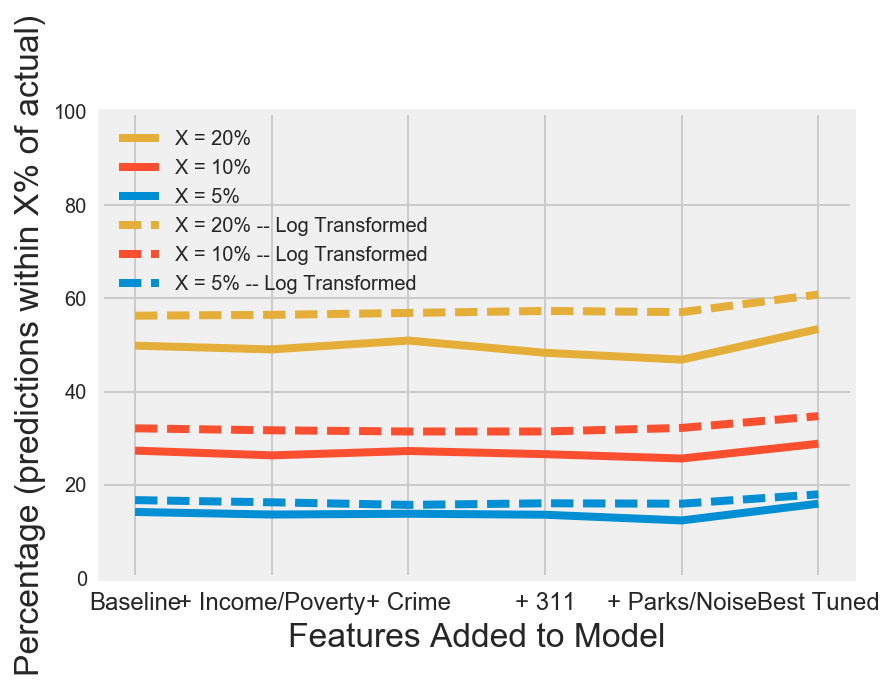

In [94]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(bnb_20, color=colors[2], label='X = 20%')
#plt.fill_between(range(6), bnb_20, color=colors[2])
plt.plot(bnb_10, color=colors[1], label='X = 10%')
#plt.fill_between(range(6), bnb_10, color=colors[1])
plt.plot(bnb_5, color=colors[0], label='X = 5%')
#plt.fill_between(range(6), bnb_5, color=colors[0])
plt.plot(bnb_20_log, '--', color=colors[2], label='X = 20% -- Log Transformed')
#plt.fill_between(range(6), bnb_20, color=colors[2])
plt.plot(bnb_10_log, '--', color=colors[1], label='X = 10% -- Log Transformed')
#plt.fill_between(range(6), bnb_10, color=colors[1])
plt.plot(bnb_5_log, '--', color=colors[0], label='X = 5% -- Log Transformed')
#plt.fill_between(range(6), bnb_5, color=colors[0])

plt.ylim(0,100)
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Percentage (predictions within X% of actual)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=10)
# plt.savefig('bnb_percents_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show()

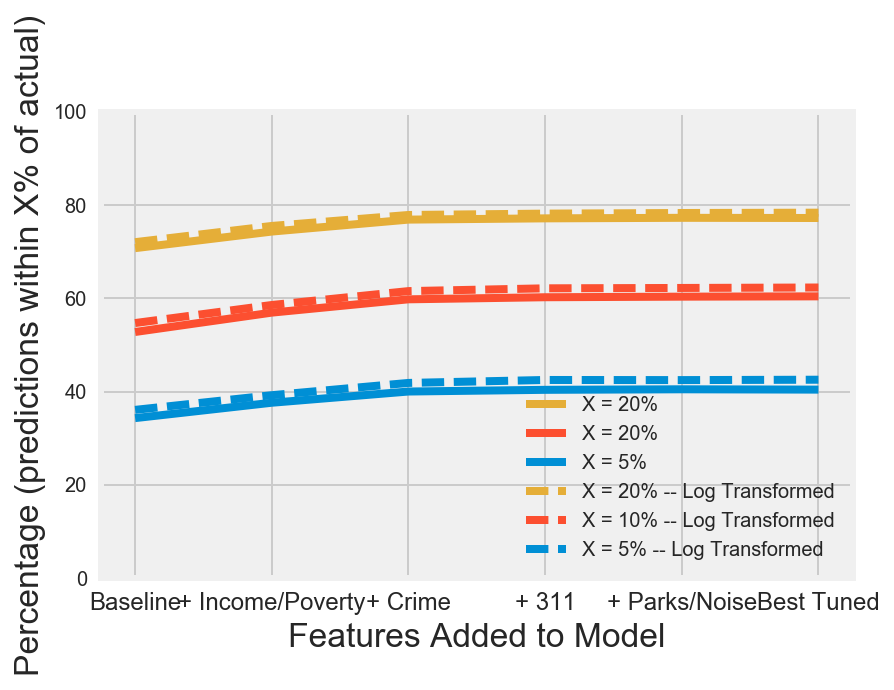

In [95]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(ass_20, color=colors[2], label='X = 20%')
#plt.fill_between(range(6), ass_20, color=colors[2])
plt.plot(ass_10, color=colors[1], label='X = 20%')
#plt.fill_between(range(6), ass_10, color=colors[1])
plt.plot(ass_5, color=colors[0], label='X = 5%')
#plt.fill_between(range(6), ass_5, color=colors[0])
plt.plot(ass_20_log, '--', color=colors[2], label='X = 20% -- Log Transformed')
#plt.fill_between(range(6), ass_20, color=colors[2])
plt.plot(ass_10_log, '--', color=colors[1], label='X = 10% -- Log Transformed')
#plt.fill_between(range(6), ass_10, color=colors[1])
plt.plot(ass_5_log, '--', color=colors[0], label='X = 5% -- Log Transformed')
#plt.fill_between(range(6), ass_5, color=colors[0])

plt.ylim(0,100)
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Percentage (predictions within X% of actual)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=10)
# plt.savefig('ass_percents_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show()

The curves below indicate that the Assessor model prediction accuracy improves with the addition of geospatial data.

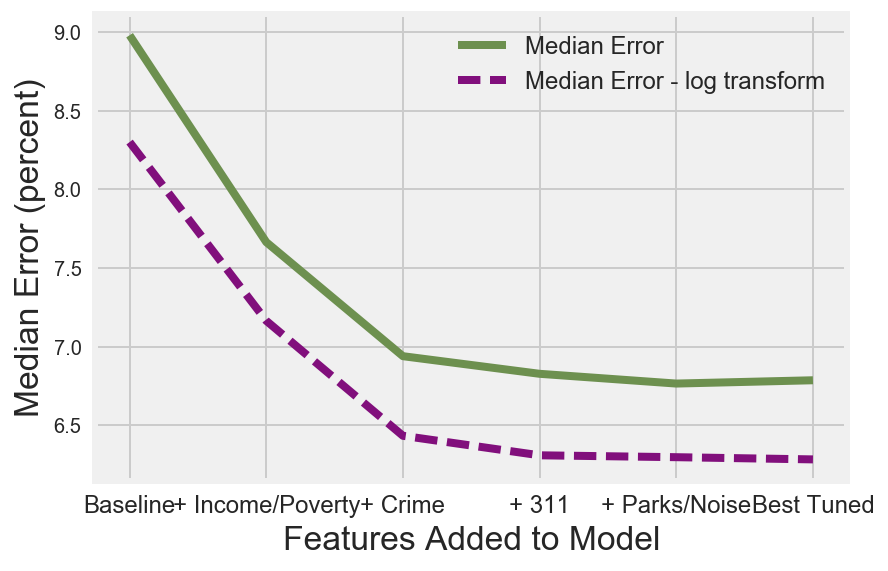

In [98]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(ass_mep, color=colors[3], label='Median Error')
plt.plot(ass_mep_log, '--', color=colors[5], label='Median Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Error (percent)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
# plt.savefig('ass_mep_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show();
#plt.ylim(5,10)

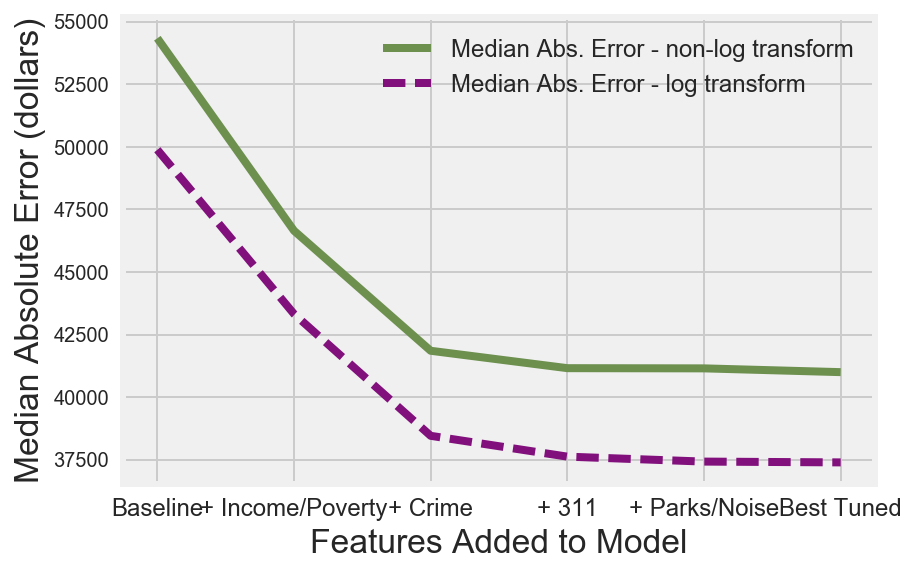

In [97]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(ass_mae, color=colors[3], label='Median Abs. Error - non-log transform')
plt.plot(ass_mae_log, '--', color=colors[5], label='Median Abs. Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Absolute Error (dollars)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
#plt.savefig('ass_mae_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show();
#plt.ylim(5,10)

The curves below indicate that the Airbnb model predictions errors are not improved by adding geospatial data. This is likely due to their anonymized locations, which can't be connected to geospatial data accurately.

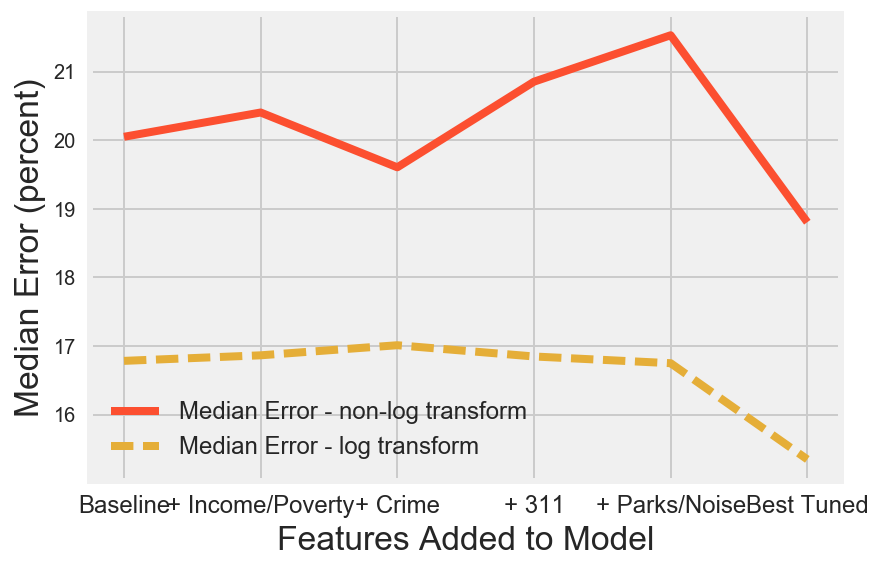

In [99]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(bnb_mep, color=colors[1], label='Median Error - non-log transform')
plt.plot(bnb_mep_log, '--', color=colors[2], label='Median Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Error (percent)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
# plt.savefig('bnb_mep_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show()
#plt.ylim(5,10)

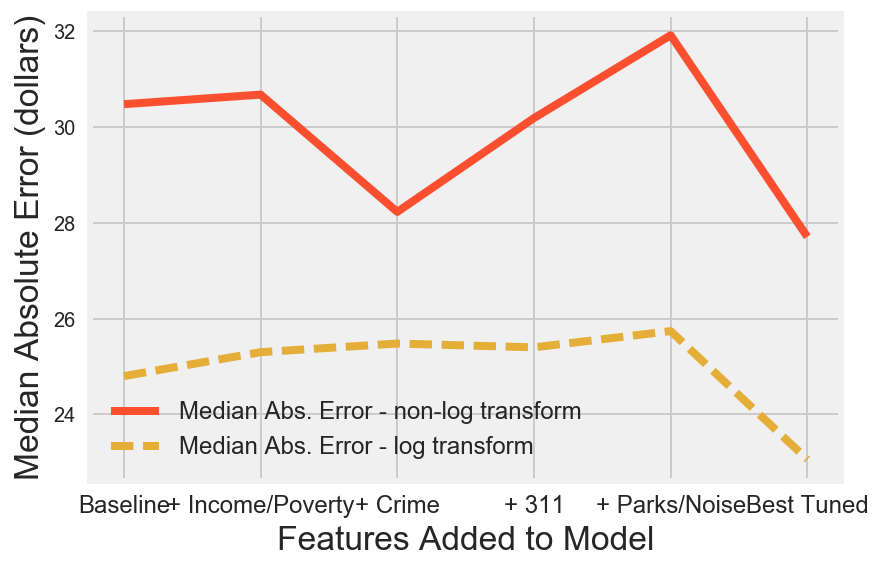

In [100]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(bnb_mae, color=colors[1], label='Median Abs. Error - non-log transform')
plt.plot(bnb_mae_log, '--', color=colors[2], label='Median Abs. Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Absolute Error (dollars)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
# plt.savefig('bnb_mae_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show()
#plt.ylim(5,10)